This notebook contains an implementation of the [SimVP](https://arxiv.org/abs/2211.12509) architecture. Vehicle behaviour prediction is performed using the KITTI dataset, predicting future frames from a given input sequence

# Initialization

##Install packages

*   `timm` library is used for weight initialization, Drop Path technique and to keep track of the loss during training
*   `h5py` package is used to read the HDF5 file containing the KITTI dataset
*   `kornia` is a differentiable library used to perform filtering operation on images (compute gradients and blurring)



In [ ]:
!pip install timm
!pip install h5py
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 14.4 MB/s eta 0:00:00


##Various imports and Google Drive mounting
For reproducibility, we set the seeds of the used library to a given value

In [ ]:
# generic imports
import math
import torch
torch.manual_seed(10)
import torch.nn as nn
import torch.nn.functional as F
import os
import os.path as osp
import random
random.seed(10)
import numpy as np
np.random.seed(0)
# from skimage.transform import resize

from torch.utils.data import Dataset
from PIL import Image
import h5py

from timm.models.layers import DropPath, trunc_normal_
import kornia
from torch import optim

from skimage.metrics import structural_similarity as cal_ssim
from tqdm import tqdm
from timm.utils import AverageMeter

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


##Download data
KITTI dataset is downloaded and organized as follows

```bash
├── data
│   ├── kitti_hkl
│   │   ├── X_train.hkl
│   │   ├── X_test.hkl
│   │   ├── X_val.hkl
│   │   ├── sources_train.hkl
│   │   ├── sources_test.hkl
│   │   ├── sources_val.hkl
│   ├── kitti_data.zip
```

In [ ]:
!mkdir -p data/kitti_hkl

!wget https://www.dropbox.com/s/rpwlnn6j39jjme4/kitti_data.zip?dl=0 -O data/kitti_data.zip
!unzip data/kitti_data.zip -d data/kitti_hkl

--2023-06-20 07:17:48--  https://www.dropbox.com/s/rpwlnn6j39jjme4/kitti_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rpwlnn6j39jjme4/kitti_data.zip [following]
--2023-06-20 07:17:48--  https://www.dropbox.com/s/raw/rpwlnn6j39jjme4/kitti_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7a1632a87b71d98a47eafbce16.dl.dropboxusercontent.com/cd/0/inline/B-UaHpcemMpBitxEr_2eZBWi2StgtWqIpAVcuLtBgSMiG0DDeWlPk6uclTAqsyogkPYKCcyevoX4e95uLjaG3cRo6Sx1FkozNtuyV2cVOx2MKsraoMX_pqzAgfS-H3wh87rTnKCwPncbGj6Lj-cZ8QpWzuHIQJkoHGD7Q98DiZLHFA/file# [following]
--2023-06-20 07:17:48--  https://uc7a1632a87b71d98a47eafbce16.dl.dropboxusercontent.com/cd/0/inline/B-UaHpcemMpBitxEr_2eZBWi2StgtWqIpAVcuLtBgSMiG0DDeWlPk6uclTAqsyogkPYKC

#General Settings




*   `use_starReLU`: if `True`, instead of the GELU activation function, `StarReLU`, introduced in [MetaFormer Baselines for Vision](https://arxiv.org/abs/2210.13452v2) , is used
*   `grayscale`: if `True`, the images are converted to grayscale
*   `log_step`: the number of epochs between each validation during training
*   `pre_seq_length, aft_seq_length`: the number of frames in input and the number of future frames to predict, respectively
*   `use_diff_dev`: if `True`, add in the loss function a Differential Divergence Regularization term, proposed in [Temporal Attention Unit: Towards Efficient Spatiotemporal Predictive Learning](https://arxiv.org/abs/2206.12126). This helps the model learn the differences between consecutive predicted frames, hence can be used only when predicting more than one future frame
*   `use_gdl`: if `True` add in the loss function a Gradient Difference Loss, proposed in [Deep multi-scale video prediction beyond mean square error](https://arxiv.org/abs/1511.05440)







In [ ]:
use_starReLU = True
grayscale = False
data_root = "data/"

resume_training = False
# training parameters
lr = 5e-3
batch_size = 32
drop_path = 0.0
num_epochs = 100
log_step = 5
use_augment = True
pre_seq_length = 10
aft_seq_length = 1

use_diff_dev = False
if use_diff_dev and aft_seq_length == 1:
  raise ValueError("Differential Divergence regularization is only allowed when predicting more than 1 future frame")

use_gdl = True

# T,C,H,W
in_shape = [pre_seq_length,1,128,160] if grayscale else [pre_seq_length,3,128,160]

# Specify folders to save the model and the training history
run_id='run18/'
save_dir = '/content/drive/MyDrive/Colab Notebooks/VisioPe/KITTI/Saving_dir/'+run_id
path_history = os.path.join(save_dir,'train_hist.pth')

os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

#StarReLU definition

In [ ]:
class StarReLU(nn.Module):
    """
    Implement StarReLU: s * relu(x) ** 2 + b
    s, b are either learnable or fixed.
    Code taken from the MetaFormer repository https://github.com/sail-sg/metaformer
    """
    def __init__(self, scale_value=1.0, bias_value=0.0,
        scale_learnable=True, bias_learnable=True,
        mode=None, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.relu = nn.ReLU(inplace=inplace)
        self.scale = nn.Parameter(scale_value * torch.ones(1),
            requires_grad=scale_learnable)
        self.bias = nn.Parameter(bias_value * torch.ones(1),
            requires_grad=bias_learnable)
    def forward(self, x):
        return self.scale * self.relu(x)**2 + self.bias

#Prediction Baseline
Returns a blurred version of the last frame in the input sequence

Blurring results in a lower error compared to simply returning the last frame

In [ ]:
class baseline_Model(nn.Module):

    def __init__(self, k_size=(3,3), sigma=(1.5, 1.5)):
        super(baseline_Model, self).__init__()
        self.k_size = k_size
        self.sigma = sigma

    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        y = torch.zeros(B, 1, C, H, W)
        for i in range(B):
          current_seq = x_raw[i]
          last_frame = current_seq[-1]
          y[i] = last_frame
        blurred = kornia.filters.gaussian_blur2d(y[:,0,:,:,:], self.k_size, self.sigma)
        return blurred.unsqueeze(1)

#SimVPv2

##SimVPv2 modules
We adapt and document the SimVP modules offered in the model zoo of the repository [OpenSTL](https://github.com/chengtan9907/OpenSTL)

In [ ]:
class BasicConv2d(nn.Module):
    """
    It implements a 2D convolution
    if act_norm=True it also performs group normalization and applies SiLU activation
    if upsampling=True the input is upsampled 2x using the PixelShuffle method
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 upsampling=False,
                 act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if upsampling is True:
            #PixelShuffle(2) doubles height and width, and /4 the number of channels.
            #So, to have in output "out_channels" we first have a conv layer with 4*out_channels
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*4, kernel_size=kernel_size,
                          stride=1, padding=padding, dilation=dilation),
                nn.PixelShuffle(2))
        else:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation)

        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.SiLU(True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    """
    This uses the BasicConv2d module
    if downsampling=True, kernel stride is set to 2 and the input dimension is halved
    Upsampling and Downsampling flags will never be True together
    """
    def __init__(self,
                 C_in,
                 C_out,
                 kernel_size=3,
                 downsampling=False,
                 upsampling=False,
                 act_norm=True):
        super(ConvSC, self).__init__()

        stride = 2 if downsampling is True else 1
        padding = (kernel_size - stride + 1) // 2

        self.conv = BasicConv2d(C_in, C_out, kernel_size=kernel_size, stride=stride,
                                upsampling=upsampling, padding=padding, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y

class AttentionModule(nn.Module):
    """This implements the gated spatiotemporal attention (gSTA) module"""

    def __init__(self, num_channels, kernel_size, dilation=3):
        super().__init__()
        # KxK convolution is decomposed into:
        #   (2d - 1) x (2d - 1) depth-wise convolution
        #   K/d x K/d depth-wise dilation convolution with dilation d
        #   1 x 1 convolution
        # Hereafter, K is the kernel_size passed to the constructor.

        # kernel size and padding for depth wise conv. H,W of the input stay unchanged
        dw_k = 2 * dilation - 1
        dw_p = (dw_k - 1) // 2

        # kernel size and padding for depth wise dilation conv. H,W of the input stay unchanged.
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1) # the second term keeps the size of the kernel odd
        dd_p = (dilation * (dd_k - 1) // 2)

        self.depth_wise_conv = nn.Conv2d(num_channels, num_channels, kernel_size=dw_k, padding=dw_p, groups=num_channels)
        self.depth_wise_dil_conv = nn.Conv2d(
            num_channels, num_channels, kernel_size=dd_k, padding=dd_p, groups=num_channels, dilation=dilation)

        #channelwise 1x1 convolution
        self.conv1 = nn.Conv2d(num_channels, 2*num_channels, 1)

    def forward(self, x):
        x = self.depth_wise_conv(x)
        x = self.depth_wise_dil_conv(x)

        f_g = self.conv1(x)

        #split along the channel dimension.
        split_dim = f_g.shape[1] // 2

        f_x, g_x = torch.split(f_g, split_dim, dim=1)
        return torch.sigmoid(g_x) * f_x

##Implementation of the attention block
The following code implements the Gated SpatioTemporal Attention block with the same structure proposed in [Visual Attention Networks](https://arxiv.org/abs/2202.09741). The following image represents the module `GASubBlock`, which contains also the modules `MixMLP, SpatialAttention`. The *d* stands for depth-wise convolution

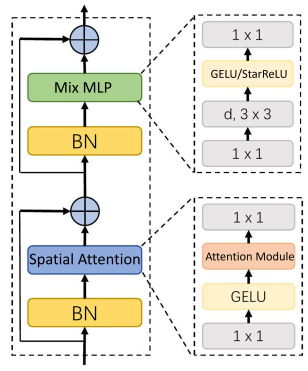

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, d_model, kernel_size=21, attn_shortcut=True):
        super().__init__()

        self.proj_1 = nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.activation = nn.GELU()                          # GELU
        self.spatial_gating_unit = AttentionModule(d_model, kernel_size)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.attn_shortcut = attn_shortcut

    def forward(self, x):
        if self.attn_shortcut:
            shortcut = x.clone()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        if self.attn_shortcut:
            x = x + shortcut
        return x

class MixMlp(nn.Module):
    def __init__(self,
                 in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)  # 1x1
        self.dwconv = nn.Conv2d(hidden_features, hidden_features, kernel_size=3, padding=1, bias=True, groups=hidden_features) # 3x3 depth-wise convolution
        self.act = act_layer()                                 # GELU
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1) # 1x1
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class GASubBlock(nn.Module):
    def __init__(self, dim, kernel_size=21, mlp_ratio=4.,
                 drop=0., drop_path=0.1, init_value=1e-2, act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(dim)
        self.attn = SpatialAttention(dim, kernel_size)

        # DropPath is used in correspondence of the residual connection on the main route.
        # It randomly sets to 0 entire tensors in the batch
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = nn.BatchNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MixMlp(
            in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop) #

        self.layer_scale_1 = nn.Parameter(init_value * torch.ones((dim)), requires_grad=True)
        self.layer_scale_2 = nn.Parameter(init_value * torch.ones((dim)), requires_grad=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = x + self.drop_path(
            self.layer_scale_1.unsqueeze(-1).unsqueeze(-1) * self.attn(self.norm1(x)))
        x = x + self.drop_path(
            self.layer_scale_2.unsqueeze(-1).unsqueeze(-1) * self.mlp(self.norm2(x)))
        return x

##SimVPv2 Model
The overall architecture of the SimVP model  accepts as input a tensor of shape $\small B \times T \times C \times H \times W$. It is based on the following structure:


*   `Spatial encoder` : the input to the encoder is reshaped as $\small (B \times T) \times C \times H \times W$. It consists of a sequence of 4 convolutional layers that maps the high-dimensional input frames into a low-dimensional latent space
*   `MidMetaNet` : the hidden representation is reshaped as $\small B \times (T \times C) \times H \times W$. This Spatio Temporal module is made up of a stack of 4 `GASubBlock` modules
*   `Spatial decoder` : the input is reshaped again to $\small (B \times T) \times C \times H \times W$. A sequence of 4 convolutional layers decodes the latent space into the predicted future frames. The output tensor of the network has the same shape of the input





In [ ]:
class SimVP_Model(nn.Module):
    def __init__(self, in_shape, hid_S=16, hid_T=256,
                 mlp_ratio=8., drop=0.0, drop_path=0.0, spatio_kernel_enc=3,
                 spatio_kernel_dec=3):
        super(SimVP_Model, self).__init__()
        T, C, H, W = in_shape  # T is pre_seq_length

        # Four encoder and four decoder blocks
        self.encoder = nn.Sequential(
                ConvSC(C, hid_S, spatio_kernel_enc, downsampling=False),
                ConvSC(hid_S, hid_S, spatio_kernel_enc, downsampling=True),
                ConvSC(hid_S, hid_S, spatio_kernel_enc, downsampling=False),
                ConvSC(hid_S, hid_S, spatio_kernel_enc, downsampling=True),
        )

        self.decoder = nn.Sequential(
                ConvSC(hid_S, hid_S, spatio_kernel_dec, upsampling=True),
                ConvSC(hid_S, hid_S, spatio_kernel_dec, upsampling=False),
                ConvSC(hid_S, hid_S, spatio_kernel_dec, upsampling=True),
                ConvSC(hid_S, hid_S, spatio_kernel_dec, upsampling=False),
                nn.Conv2d(hid_S, C, kernel_size=1)
        )

        self.hid = MidMetaNet(T*hid_S, hid_T,
                              mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path)

    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        # a skip connection between the first encoder layer and the
        # corresponding decoder layer is used
        skip_tensor = self.encoder[0](x)
        x = skip_tensor
        x = self.encoder[1](x)
        x = self.encoder[2](x)
        embed = self.encoder[3](x)

        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.view(B*T, C_, H_, W_)

        z = self.decoder[0](hid)
        z = self.decoder[1](z)
        z = self.decoder[2](z)
        z = self.decoder[3](z+skip_tensor)
        y = self.decoder[4](z)

        y = y.view(B, T, C, H, W)

        return y


class MidMetaNet(nn.Module):
    def __init__(self, channel_in, channel_hid,
                 mlp_ratio=4., drop=0.0, drop_path=0.1):
        super(MidMetaNet, self).__init__()

        if drop_path != 0:
          dpr = [  # stochastic depth decay rule
              x.item() for x in torch.linspace(1e-2, drop_path, 4)]
        else:
          dpr = [0] * 4

        # increase the number of channels
        self.expansion = nn.Sequential(
            GASubBlock(channel_in, kernel_size=21, mlp_ratio=mlp_ratio,
          drop=drop, drop_path=dpr[0], act_layer=StarReLU if use_starReLU else nn.GELU),
            nn.Conv2d(channel_in, channel_hid, kernel_size=1))

        # middle layers
        self.middle = nn.Sequential(
            GASubBlock(channel_hid, kernel_size=21, mlp_ratio=mlp_ratio,
          drop=drop, drop_path=dpr[1], act_layer=StarReLU if use_starReLU else nn.GELU),
            GASubBlock(channel_hid, kernel_size=21, mlp_ratio=mlp_ratio,
          drop=drop, drop_path=dpr[2], act_layer=StarReLU if use_starReLU else nn.GELU),
        )

        # restore the original number of channels
        self.contraction = nn.Sequential(
            GASubBlock(channel_hid, kernel_size=21, mlp_ratio=mlp_ratio,
          drop=drop, drop_path=drop_path, act_layer=StarReLU if use_starReLU else nn.GELU),
            nn.Conv2d(channel_hid, channel_in, kernel_size=1))


    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B, T*C, H, W)

        x = self.expansion(x)
        x = self.middle(x)
        x = self.contraction(x)

        y = x.view(B, T, C, H, W)
        return y

#Metrics to evaluate
The metrics used are:


*   the Mean Squared Error $\small MSE=\sum_c^C\sum_h^H\sum_w^W\frac{1}{BT}\sum_b^B\sum_t^T(\hat{Y}_{b,t,c,h,w}-Y_{b,t,c,h,w})^2$
*   the Structural Similarity Index (SSIM) : it evaluates not only pixel-wise differences but also structural information. It compares local patterns of pixel intensity, luminance, contrast and structure to determine similarity between images. It is a value in the interval $\small [0,1]$, where a value of $\small 1$ means the images are identical



In [ ]:
def MSE(pred, true):
    return np.mean((pred-true)**2, axis=(0, 1)).sum()

def metric(pred, true, metrics=['mse'], clip_range=[0, 1]):
    """The evaluation function to output metrics.

    Args:
        pred (tensor): The prediction values of output prediction.
        true (tensor): The prediction values of output prediction.
        metrics (str | list[str]): Metrics to be evaluated.
        clip_range (list): Range of prediction to prevent overflow.
    Returns:
        dict: evaluation results
    """
    eval_res = {}
    allowed_metrics = ['mse','ssim']
    invalid_metrics = set(metrics) - set(allowed_metrics)
    if len(invalid_metrics) != 0:
        raise ValueError(f'metric {invalid_metrics} is not supported.')

    if 'mse' in metrics:
        eval_res['mse'] = MSE(pred, true)

    pred = np.maximum(pred, clip_range[0])
    pred = np.minimum(pred, clip_range[1])
    if 'ssim' in metrics:
        ssim = 0
        for b in range(pred.shape[0]):
            for f in range(pred.shape[1]):
                ssim += cal_ssim(pred[b, f].swapaxes(0, 2),
                                 true[b, f].swapaxes(0, 2), channel_axis=-1)
        eval_res['ssim'] = ssim / (pred.shape[0] * pred.shape[1])

    return eval_res


#Dataloaders
Various functions and classes to handle data

In [ ]:
def seq_to_grayscale(image_sequence):
  """
  Takes as input a tensor TxCxHxW and returns
  a Tx1xHxW tensor. The conversion from RGB to
  grayscale is done using the PIL library since it
  mantains the uint8 datatype
  """
  T, C, H, W = image_sequence.shape
  converted_sequence=np.full((T,1,H,W),0,dtype=np.uint8)
  for i in range(T):
    pil_image = Image.fromarray(image_sequence[i].transpose(1,2,0))
    gray = np.array(pil_image.convert('L'))
    converted_sequence[i] = gray[np.newaxis, ...]

  return converted_sequence


class KittiDataset(Dataset):
    """
    Custom dataset class. It stores data as uint8 and converts them to float in [0,1]
    only when queried, in the get_item method. This choice is due to GPU memory limits in Google Colab
    """
    def __init__(self, datas, indices, pre_seq_length, aft_seq_length,
                 use_augment=False):
        super(KittiDataset, self).__init__()
        #swapaxes so that it is (N, C, 128, 160)
        self.datas = seq_to_grayscale(datas.swapaxes(2, 3).swapaxes(1, 2)) if grayscale else datas.swapaxes(2, 3).swapaxes(1, 2)
        print(datas.shape)
        self.indices = indices
        self.pre_seq_length = pre_seq_length
        self.aft_seq_length = aft_seq_length
        self.use_augment = use_augment

    def _augment_seq(self, imgs, crop_scale=0.95):
        """
        Augmentations: random cropping and random horizontal flip
        """
        _, _, h, w = imgs.shape  # original shape, e.g., [10, 3, 128, 160]
        imgs = F.interpolate(imgs, scale_factor=1 / crop_scale, mode='bilinear')
        _, _, ih, iw = imgs.shape
        # Random Crop
        x = np.random.randint(0, ih - h + 1)
        y = np.random.randint(0, iw - w + 1)
        imgs = imgs[:, :, x:x+h, y:y+w]
        # Random Flip
        if random.randint(0, 1):
            imgs = torch.flip(imgs, dims=(3, ))  # horizontal flip
        return imgs

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        batch_ind = self.indices[i]
        begin = batch_ind
        end1 = begin + self.pre_seq_length
        end2 = end1 + self.aft_seq_length

        # Conversion from uint8 to float and normalization in [0,1] here,
        # not on the whole dataset when we load it from the hkl file
        data = torch.tensor(self.datas[begin:end1, ::]).float()/255.0
        labels = torch.tensor(self.datas[end1:end2, ::]).float()/255.0

        if self.use_augment:
            imgs = self._augment_seq(torch.cat([data, labels], dim=0), crop_scale=0.95)
            data = imgs[:self.pre_seq_length, ...]
            labels = imgs[self.pre_seq_length:self.pre_seq_length+self.aft_seq_length, ...]
        return data, labels

class DataProcess(object):
    """
    Class that loads raw data and extract indices to have consecutive frames.
    The images are loaded as uint8 type.
    """
    def __init__(self, input_param):
        self.paths = input_param['paths']
        self.seq_len = input_param['seq_length']

    def load_data(self, mode='train'):
        """Loads the dataset.
        Args:
          paths: paths of train/test dataset.
          mode: Training or testing.
        Returns:
          A dataset and indices of the sequence.
        """
        kitti_root = self.paths['kitti']

        data=[]
        with h5py.File(osp.join(kitti_root, 'X_' + mode + '.hkl'), 'r') as f:
          dataset=f['data_0']
          data = dataset[()]

        fileidx=[]
        with h5py.File(osp.join(kitti_root, 'sources_' + mode + '.hkl'), 'r') as f:
          dataset=f['data_0']
          fileidx = dataset[()]
        # uses the sources files to index the images and extract a chronologically ordered sequence
        indices = []
        index = len(fileidx) - 1
        while index >= self.seq_len - 1:
            if fileidx[index] == fileidx[index - self.seq_len + 1]:
                indices.append(index - self.seq_len + 1)
                index -= self.seq_len - 1
            index -= 1
        return data, indices

def load_data(batch_size, val_batch_size, data_root,
              pre_seq_length=10, aft_seq_length=1, use_augment=False):
    """
    External function that uses the above classes and returns
    the dataloader for training, validation and testing
    """
    os.makedirs(osp.join(data_root, 'kitti_hkl'), exist_ok=True)
    input_param = {
        'paths': {'kitti': osp.join(data_root, 'kitti_hkl')},
        'seq_length': (pre_seq_length + aft_seq_length),
    }
    input_handle = DataProcess(input_param)

    train_data, train_idx = input_handle.load_data('train')
    test_data, test_idx = input_handle.load_data('test')
    val_data, val_idx = input_handle.load_data('val')

    train_set = KittiDataset(
        train_data, train_idx, pre_seq_length, aft_seq_length, use_augment=use_augment)

    test_set = KittiDataset(
        test_data, test_idx, pre_seq_length, aft_seq_length, use_augment=False)

    val_set = KittiDataset(
        val_data, val_idx, pre_seq_length, aft_seq_length, use_augment=False)

    # For reproducibility
    g = torch.Generator()
    g.manual_seed(0)

    dataloader_train = torch.utils.data.DataLoader(train_set,
                                     batch_size=batch_size,
                                     shuffle=True,
                                      worker_init_fn=seed_worker,
                                      generator=g,
                                     pin_memory=True, drop_last=True)

    dataloader_vali = torch.utils.data.DataLoader(val_set,
                                     batch_size=batch_size,
                                     shuffle=True,
                                      worker_init_fn=seed_worker,
                                      generator=g,
                                     pin_memory=True, drop_last=False)

    dataloader_test = torch.utils.data.DataLoader(test_set,
                                    batch_size=val_batch_size,
                                    shuffle=False,
                                      worker_init_fn=seed_worker,
                                      generator=g,
                                    pin_memory=True, drop_last=False)

    return dataloader_train, dataloader_vali, dataloader_test

# For reproducibility
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


#Loss function class
We use a loss function composed of possibly three terms:


*   *Mean Squared Error Loss* : different from the previously defined since here the average is computed across all axes. This allows for a more stable training
*   *Gradient Difference Loss* : $\small GDL=\frac{1}{BTCHW}\sum(Y_x-\hat{Y}_x)^2+(Y_y-\hat{Y}_y)^2$ where $\small Y,\hat{Y}$ are the predicted and ground truth tensors, $\small I_x,I_y$ are the gradient along $\small x,y$ of the tensor $\small I$ and the summation is along all the $\small 5$ tensor dimensions
*   *Differential Divergence Regularization* : it is the Kullback-Leibler divegence between the probability distributions $\small \sigma(\Delta\hat{Y}), \sigma(\Delta Y)$ where $\small \sigma(\cdot)$ is the softmax and $\Delta\hat{Y}, \Delta Y$ are the forward differences of the predicted and ground truth frames

In [ ]:
def diff_div_reg(pred_y, batch_y, tau=0.1, eps=1e-12):
    """
    Differential Divergence Regularization term.
    Code taken from https://github.com/chengtan9907/OpenSTL
    """
    B, T, C = pred_y.shape[:3]
    gap_pred_y = (pred_y[:, 1:] - pred_y[:, :-1]).reshape(B, T-1, -1)
    gap_batch_y = (batch_y[:, 1:] - batch_y[:, :-1]).reshape(B, T-1, -1)
    softmax_gap_p = F.softmax(gap_pred_y / tau, -1)
    softmax_gap_b = F.softmax(gap_batch_y / tau, -1)
    loss_gap = softmax_gap_p * \
        torch.log(softmax_gap_p / (softmax_gap_b + eps) + eps)
    return loss_gap

def gdl_criterion(batch_pred, batch_true):
    """
    Gradient Difference Loss implemented using the differentiable library kornia
    """
    B, T, C, H , W = batch_pred.shape
    batch_pred = batch_pred.reshape(B*T, C, H, W)

    batch_true = batch_true.reshape(B*T, C, H, W)

    # it returns a tensor (B*T)xCx2xHxW with horizontal and vertical gradients
    pred_grads = kornia.filters.spatial_gradient(batch_pred)
    dx_pred = torch.abs(pred_grads[:,:,0,:,:])
    dy_pred = torch.abs(pred_grads[:,:,1,:,:])

    true_grads = kornia.filters.spatial_gradient(batch_true)
    dx_true = torch.abs(true_grads[:,:,0,:,:])
    dy_true = torch.abs(true_grads[:,:,1,:,:])

    diff_gradients = (dx_true - dx_pred)**2 + (dy_true - dy_pred)**2

    return torch.mean(diff_gradients)

class CustomLoss(nn.Module):
    def __init__(self, use_gdl = False, use_diff_dev = False,
                 alpha = 0.5, beta = 0.1):
        super(CustomLoss, self).__init__()
        self.use_gdl = use_gdl
        self.use_diff_dev = use_diff_dev
        self.mse = nn.MSELoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, prediction, target):
        gdl = gdl_criterion(prediction, target) if self.use_gdl else 0
        diff_dev = diff_div_reg(prediction, target).mean() if self.use_diff_dev else 0
        mse = self.mse(prediction, target)

        return mse + self.alpha*gdl + self.beta*diff_dev

#Helper functions


*   `train_one_epoch` : it performs one training epoch on the given model
*   `test_model` : given a dataloader, it tests the model on said data and returns the desired metrics, MSE and/or SSIM
*    `predict` : the output tensor of the model has always the same shape of the input, so also the temporal dimension $\small T$ is the same. This method, using `aft_seq_length`, returns only the intended number of future frames
*   `get_optim_scheduler` : returns the chosen optimizer and learning rate scheduler



In [ ]:
def train_one_epoch(dataloader_train, model, pre_seq_length, aft_seq_length, loss_fn, optimizer, scheduler):
  losses_m = AverageMeter()
  train_pbar = tqdm(dataloader_train)
  model.train()
  for (X, y) in train_pbar:
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = predict(X, pre_seq_length, aft_seq_length)
      loss = loss_fn(pred, y)

      losses_m.update(loss.item(), X.size(0))

      # Backpropagation
      loss.backward()
      optimizer.step()


      scheduler.step()
      log_buffer = 'train loss: {:.4f}'.format(loss.item())
      train_pbar.set_description(log_buffer)

  return losses_m

def test_model(dataloader_test, model, pre_seq_length, aft_seq_length, loss_fn, metrics=['mse'], gather_data=False):
  results=[]
  eval_res={}
  losses_m = AverageMeter()

  model.eval()
  for i, (X, y) in enumerate(dataloader_test):
    with torch.no_grad():
      X, y = X.to(device), y.to(device)
      pred_y = predict(X, pre_seq_length, aft_seq_length)
    if gather_data:
      results.append(dict(zip(['inputs', 'preds', 'trues'],
                            [X.cpu().numpy(), pred_y.cpu().numpy(), y.cpu().numpy()])))
      break # otherwise full RAM
    else:
      eval_res = metric(pred_y.cpu().numpy(), y.cpu().numpy(), metrics=metrics)
      losses_m.update((loss_fn(pred_y.to(device), y)).cpu().item(),X.size(0))
      for k in eval_res.keys():
          eval_res[k] = eval_res[k].reshape(1) #reshape otherwise it is a 0-dim array and cannot be concatenated

      results.append(eval_res)

    torch.cuda.empty_cache()

  results_all = {}
  for k in results[0].keys():
      results_all[k] = np.concatenate([batch[k] for batch in results], axis=0)

  results_all['loss'] = losses_m.avg

  return results_all

def predict(batch_x, pre_seq_length=10, aft_seq_length=10):
    """Forward the model"""
    pred_y = model(batch_x)

    if aft_seq_length < pre_seq_length:
        pred_y = pred_y[:, :aft_seq_length]
    # If you want to predict more frames than the ones in input, feed back
    # to the model its previous predictions until the desired number of frames is predicted
    elif aft_seq_length > pre_seq_length:
        pred_y = []
        d = aft_seq_length // pre_seq_length
        m = aft_seq_length % pre_seq_length

        cur_seq = batch_x.clone()
        for _ in range(d):
            cur_seq = model(cur_seq)
            pred_y.append(cur_seq)

        if m != 0:
            cur_seq = model(cur_seq)
            pred_y.append(cur_seq[:, :m])

        pred_y = torch.cat(pred_y, dim=1)

    return pred_y

def get_optim_scheduler(lr, epoch, model, steps_per_epoch):
  parameters = model.parameters()

  optimizer = optim.Adam(parameters, lr=lr, weight_decay=0)

  total_steps = epoch * steps_per_epoch
  lr_scheduler = optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=lr,
      total_steps=total_steps,
      final_div_factor=1e4)
  by_epoch = False

  return optimizer, lr_scheduler

#Save and Load model functions
Functions used to save and load the data needed to resume a training

In [ ]:
def save(name, epoch, model, optimizer, scheduler, min_val_loss):
        # Saving models and meta data to checkpoints
        checkpoint = {
            'epoch': epoch,
            'optimizer': optimizer.state_dict(),
            'state_dict': model.state_dict(),
            'scheduler': scheduler.state_dict(),
            'min_val_loss' : min_val_loss}

        torch.save(checkpoint, os.path.join(save_dir, name + '.pth'))

def load(name, epoch, model, optimizer, scheduler):

        if not os.path.isfile(os.path.join(save_dir, name + '.pth')):
            raise FileNotFoundError(f"No checkpoint file found")

        # Load the checkpoint
        checkpoint = torch.load(os.path.join(save_dir, name + '.pth'))

        # Load the model state_dict
        model.load_state_dict(checkpoint['state_dict'])

        # Load the optimizer state_dict
        optimizer.load_state_dict(checkpoint['optimizer'])

        # Load the scheduler state_dict
        scheduler.load_state_dict(checkpoint['scheduler'])

        # Get the last epoch
        epoch[0] = checkpoint['epoch']

        # Return the minimum validation loss. It is useful when
        # resuming training to keep track of the best model
        return checkpoint['min_val_loss']

#Load the data

In [ ]:
dataloader_train, dataloader_vali, dataloader_test = load_data(batch_size=batch_size, val_batch_size=batch_size, \
                                                               data_root=data_root, pre_seq_length=pre_seq_length, aft_seq_length=aft_seq_length, use_augment=use_augment)

(41396, 128, 160, 3)
(832, 128, 160, 3)
(154, 128, 160, 3)


#SimVP model instantiation

In [ ]:
#model parameters
# kernel size in the encoder and decoder
spatio_kernel_enc = 3
spatio_kernel_dec = 3

# hidden channels in the encoder/decoder
hid_S = 16
# hidden channels in the temporal blocks in the middle of the net
hid_T = 256

# define the loss function
loss_fn = CustomLoss(use_gdl = use_gdl, use_diff_dev = use_diff_dev)

curr_epoch = [0]

model = SimVP_Model(in_shape, hid_S, hid_T, drop_path=drop_path, \
                    spatio_kernel_enc=spatio_kernel_enc, spatio_kernel_dec=spatio_kernel_dec).to(device)

optimizer, scheduler = get_optim_scheduler(lr, num_epochs, model, len(dataloader_train))

In [ ]:
from torchsummary import summary
summary(model, input_size=(pre_seq_length, 3, 128, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 160]             448
         GroupNorm-2         [-1, 16, 128, 160]              32
              SiLU-3         [-1, 16, 128, 160]               0
       BasicConv2d-4         [-1, 16, 128, 160]               0
            ConvSC-5         [-1, 16, 128, 160]               0
            Conv2d-6           [-1, 16, 64, 80]           2,320
         GroupNorm-7           [-1, 16, 64, 80]              32
              SiLU-8           [-1, 16, 64, 80]               0
       BasicConv2d-9           [-1, 16, 64, 80]               0
           ConvSC-10           [-1, 16, 64, 80]               0
           Conv2d-11           [-1, 16, 64, 80]           2,320
        GroupNorm-12           [-1, 16, 64, 80]              32
             SiLU-13           [-1, 16, 64, 80]               0
      BasicConv2d-14           [-1, 16,

#Training phase
In this phase, we train the previously instantiated SimVP model for a given number of epochs. Training takes about 2min35s per epoch, so about 4h30min to complete a 100 epoch

##Training loop

In [ ]:
if resume_training:
  min_val_loss = load('latest_model',curr_epoch,model,optimizer,scheduler)
  curr_epoch[0] = curr_epoch[0]+1 # start from the next epoch
  history = torch.load(path_history)
  train_loss_per_epoch = history['train_loss']
  vali_loss_per_epoch = history['vali_loss']
else:
  min_val_loss = np.inf
  train_loss_per_epoch = []
  vali_loss_per_epoch = []

curr_epoch=curr_epoch[0]

for epoch in range(curr_epoch,num_epochs):
  loss = train_one_epoch(dataloader_train, model, pre_seq_length, aft_seq_length, loss_fn, optimizer, scheduler)
  train_loss_per_epoch.append(loss.avg)

  if epoch % log_step == 0:
    with torch.no_grad():
      results=test_model(dataloader_vali, model, pre_seq_length, aft_seq_length, loss_fn)
      vali_loss_per_epoch.append(results["loss"])

    cur_lr = optimizer.param_groups[0]['lr']
    print('Epoch: {0}, | Lr: {1:.7f} | Train Loss: {2:.7f} | Vali Loss: {3:.7f}\n'.format(
                        epoch + 1, cur_lr, loss.avg, results["loss"]))
    # we keep track of the best model in terms of loss on the validation set
    if min_val_loss > results["loss"]:
      min_val_loss = results["loss"]
      save('best_model',epoch,model,optimizer,scheduler,min_val_loss)

  save('latest_model',epoch,model,optimizer,scheduler, min_val_loss)
  # saeìve for later plotting
  torch.save({'train_loss': train_loss_per_epoch, 'vali_loss': vali_loss_per_epoch}, path_history)

  torch.cuda.empty_cache()

train loss: 0.0055: 100%|██████████| 107/107 [02:34<00:00,  1.44s/it]


Epoch: 91, | Lr: 0.0002008 | Train Loss: 0.0049071 | Vali Loss: 0.0122754



train loss: 0.0043: 100%|██████████| 107/107 [02:36<00:00,  1.46s/it]


Epoch: 96, | Lr: 0.0000400 | Train Loss: 0.0048534 | Vali Loss: 0.0122927



train loss: 0.0042: 100%|██████████| 107/107 [02:33<00:00,  1.44s/it]


#Evaluation phase
Here we evaluate the baseline and the SimVP model. In each subsection, we define a model, compute the MSE and SSIM metric, and also show the input and predicted frames

##Baseline Evaluation

In [ ]:
# Loss function needed for evaluation
loss_fn = CustomLoss(use_diff_dev = False)

model=baseline_Model().to(device)
model.eval()
results=test_model(dataloader_test, model, pre_seq_length, aft_seq_length, loss_fn, metrics=['mse','ssim'], gather_data=False)
print(results)
print(np.mean(results['mse']))
print(np.mean(results['ssim']))

{'mse': array([ 682.31836, 1272.7937 ,  934.6941 ], dtype=float32), 'ssim': array([0.71442112, 0.60267871, 0.6602638 ]), 'loss': 0.0158084254215161}
963.26874
0.6591212076671196


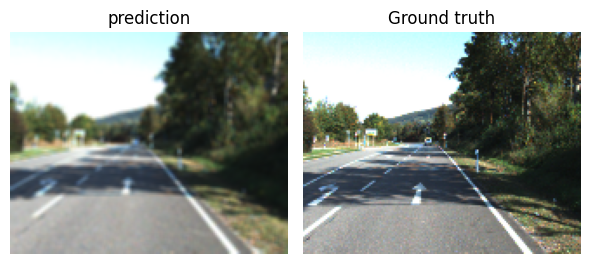

In [ ]:
import matplotlib.pyplot as plt

results=test_model(dataloader_test, model, pre_seq_length, aft_seq_length, loss_fn, metrics=['mse','ssim'], gather_data=True)

preds = results["preds"][0]  # Shape: [1, 3, 128, 160]
trues = results["trues"][0]  # Shape: [1, 3, 128, 160]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))

if grayscale:
  ax1.imshow(preds.squeeze(0).transpose(1,2,0), cmap='gray')
else:
  ax1.imshow(preds.squeeze(0).transpose(1,2,0))
ax1.set_title("prediction")
ax1.axis('off')

if grayscale:
  ax2.imshow(trues.squeeze(0).transpose(1,2,0), cmap='gray')
else:
  ax2.imshow(trues.squeeze(0).transpose(1,2,0))

ax2.set_title("Ground truth")
ax2.axis('off')

plt.tight_layout()
plt.show()

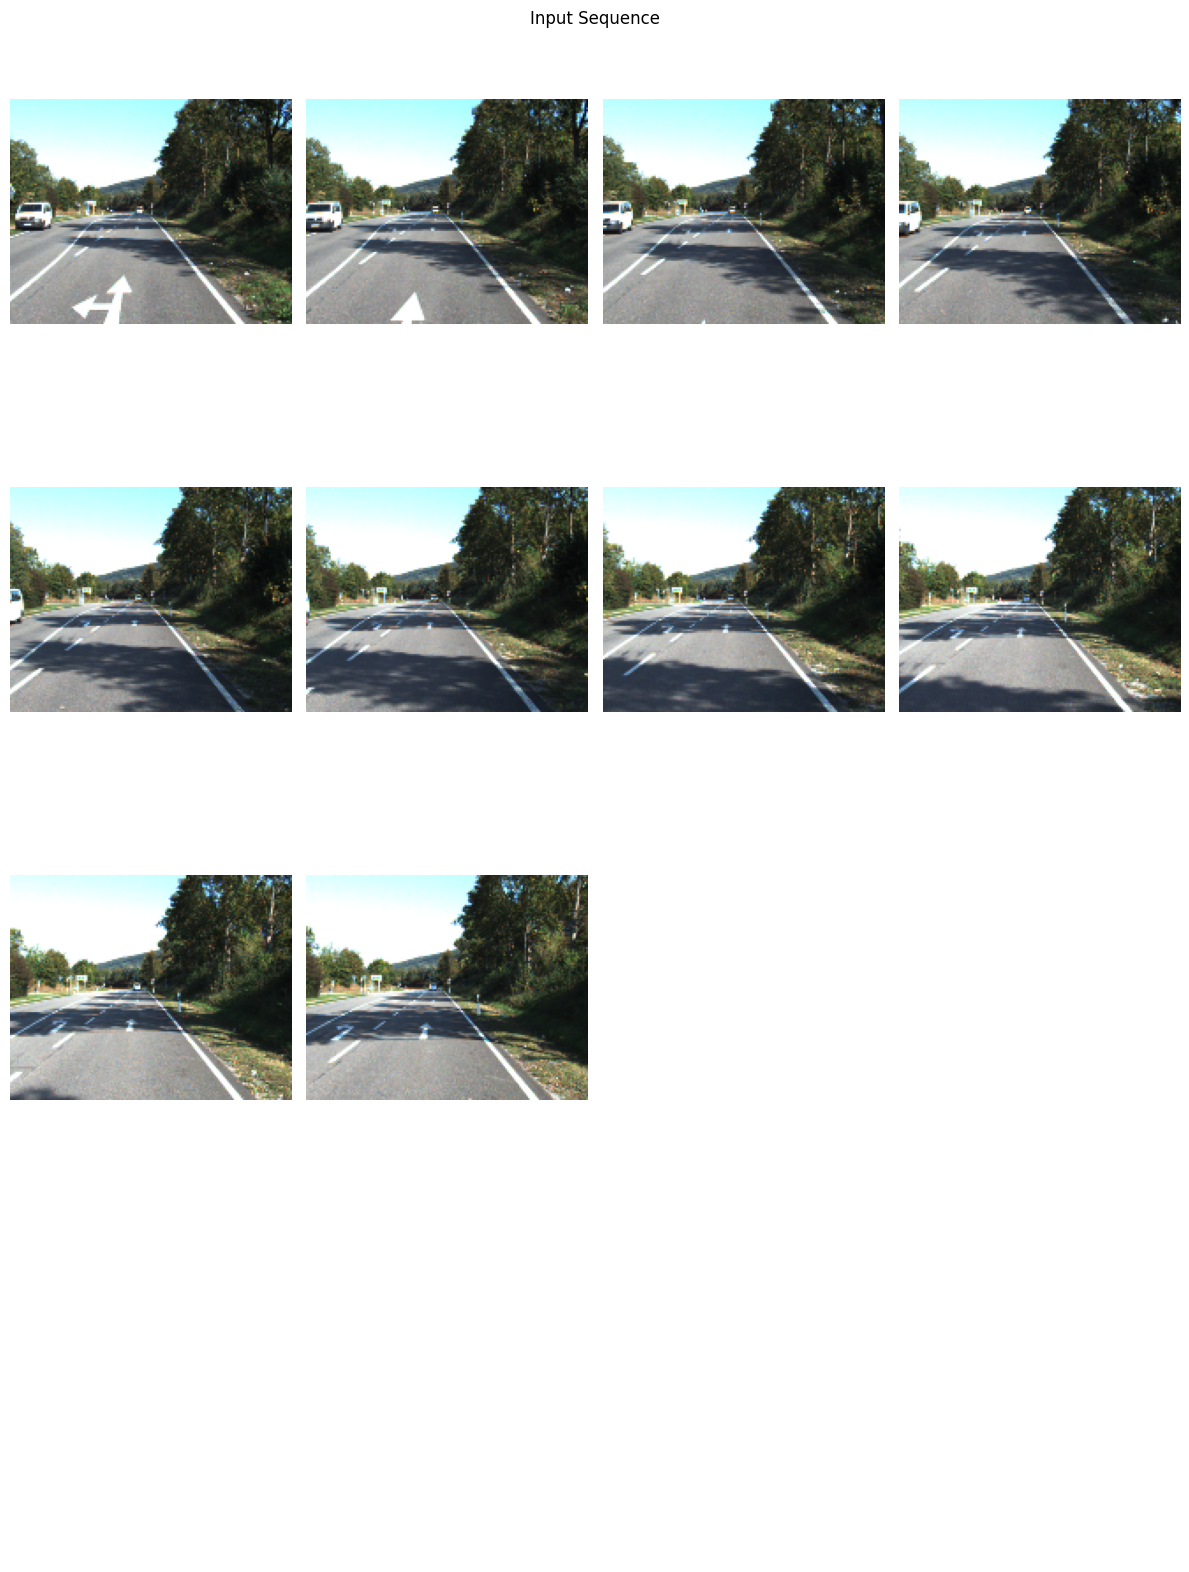

In [ ]:
inputs = results["inputs"][0] # Shape: [pre_seq_length, 3, 128,160]

# Plot the images inside the batch element
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,16))
axes=axes.flatten()
for i, ax in enumerate(axes):
    # Get the image tensor
    input_img = inputs[i].transpose(1,2,0)

    if grayscale:
      ax.imshow(input_img,cmap='gray')
    else:
      ax.imshow(input_img)
    ax.axis('off')
    if i==inputs.shape[0]-1:
      break
for j in range(pre_seq_length,nrows*ncols):
  axes[j].axis('off')

fig.suptitle("Input Sequence")
plt.tight_layout()
plt.show()

##SimVP Evaluation

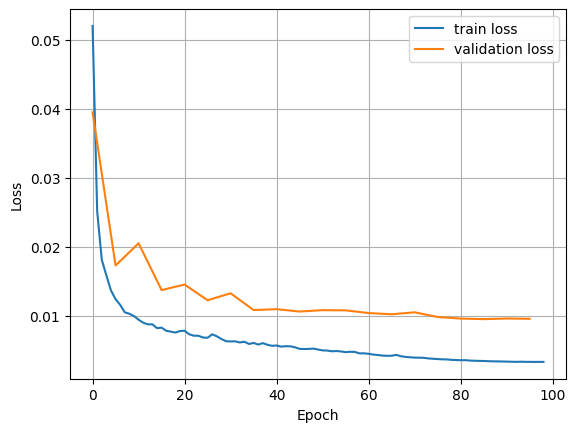

In [ ]:
model = SimVP_Model(in_shape, hid_S, hid_T, drop_path=drop_path, \
                    spatio_kernel_enc=spatio_kernel_enc, spatio_kernel_dec=spatio_kernel_dec).to(device)
curr_epoch = [0]

load('latest_model',curr_epoch,model,optimizer,scheduler)
curr_epoch = curr_epoch[0]
# Put the model in evaluation mode
model.eval();

if os.path.exists(path_history):
    import matplotlib.pyplot as plt

    history = torch.load(path_history)
    train_loss = history['train_loss']
    train_loss = train_loss[:curr_epoch]
    vali_loss = history['vali_loss']
    epochs_train = np.arange(curr_epoch)
    epochs_vali = epochs_train[epochs_train%log_step == 0]

    plt.plot(epochs_train, train_loss, label='train loss')
    plt.plot(epochs_vali,vali_loss, label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
results=test_model(dataloader_test, model, pre_seq_length, aft_seq_length, loss_fn, metrics=['mse','ssim'], gather_data=False)
print(results)
print(np.mean(results['mse']))
print(np.mean(results['ssim']))

{'mse': array([269.3809, 471.5771, 467.9757], dtype=float32), 'ssim': array([0.84284416, 0.80620498, 0.81075511]), 'loss': 0.0073415427779157955}
402.9779
0.8199347489598123


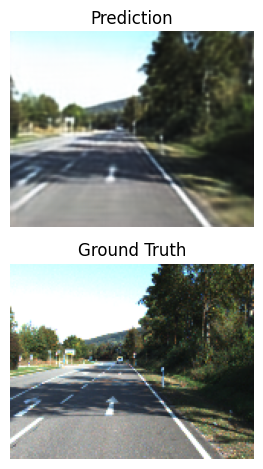

In [ ]:
import matplotlib.pyplot as plt
results=test_model(dataloader_test, model, pre_seq_length, aft_seq_length, loss_fn, metrics=['mse','ssim'], gather_data=True)

preds = results["preds"][0]  # Shape: [aft_seq_length, 3, 128, 160]
trues = results["trues"][0]  # Shape: [aft_seq_length, 3, 128, 160]

fig, axes = plt.subplots(2, aft_seq_length)

if aft_seq_length == 1:
  axes=axes[::,np.newaxis]

for i in range(aft_seq_length):
  if grayscale:
    axes[0,i].imshow(preds[i].transpose(1,2,0),cmap='gray')
    axes[1,i].imshow(trues[i].transpose(1,2,0),cmap='gray')
  else:
    axes[0,i].imshow(preds[i].transpose(1,2,0))
    axes[1,i].imshow(trues[i].transpose(1,2,0))

  axes[0, i].axis('off')
  axes[1, i].axis('off')

axes[0,aft_seq_length//2].set_title("Prediction")
axes[1,aft_seq_length//2].set_title("Ground Truth")


plt.tight_layout()
plt.show()

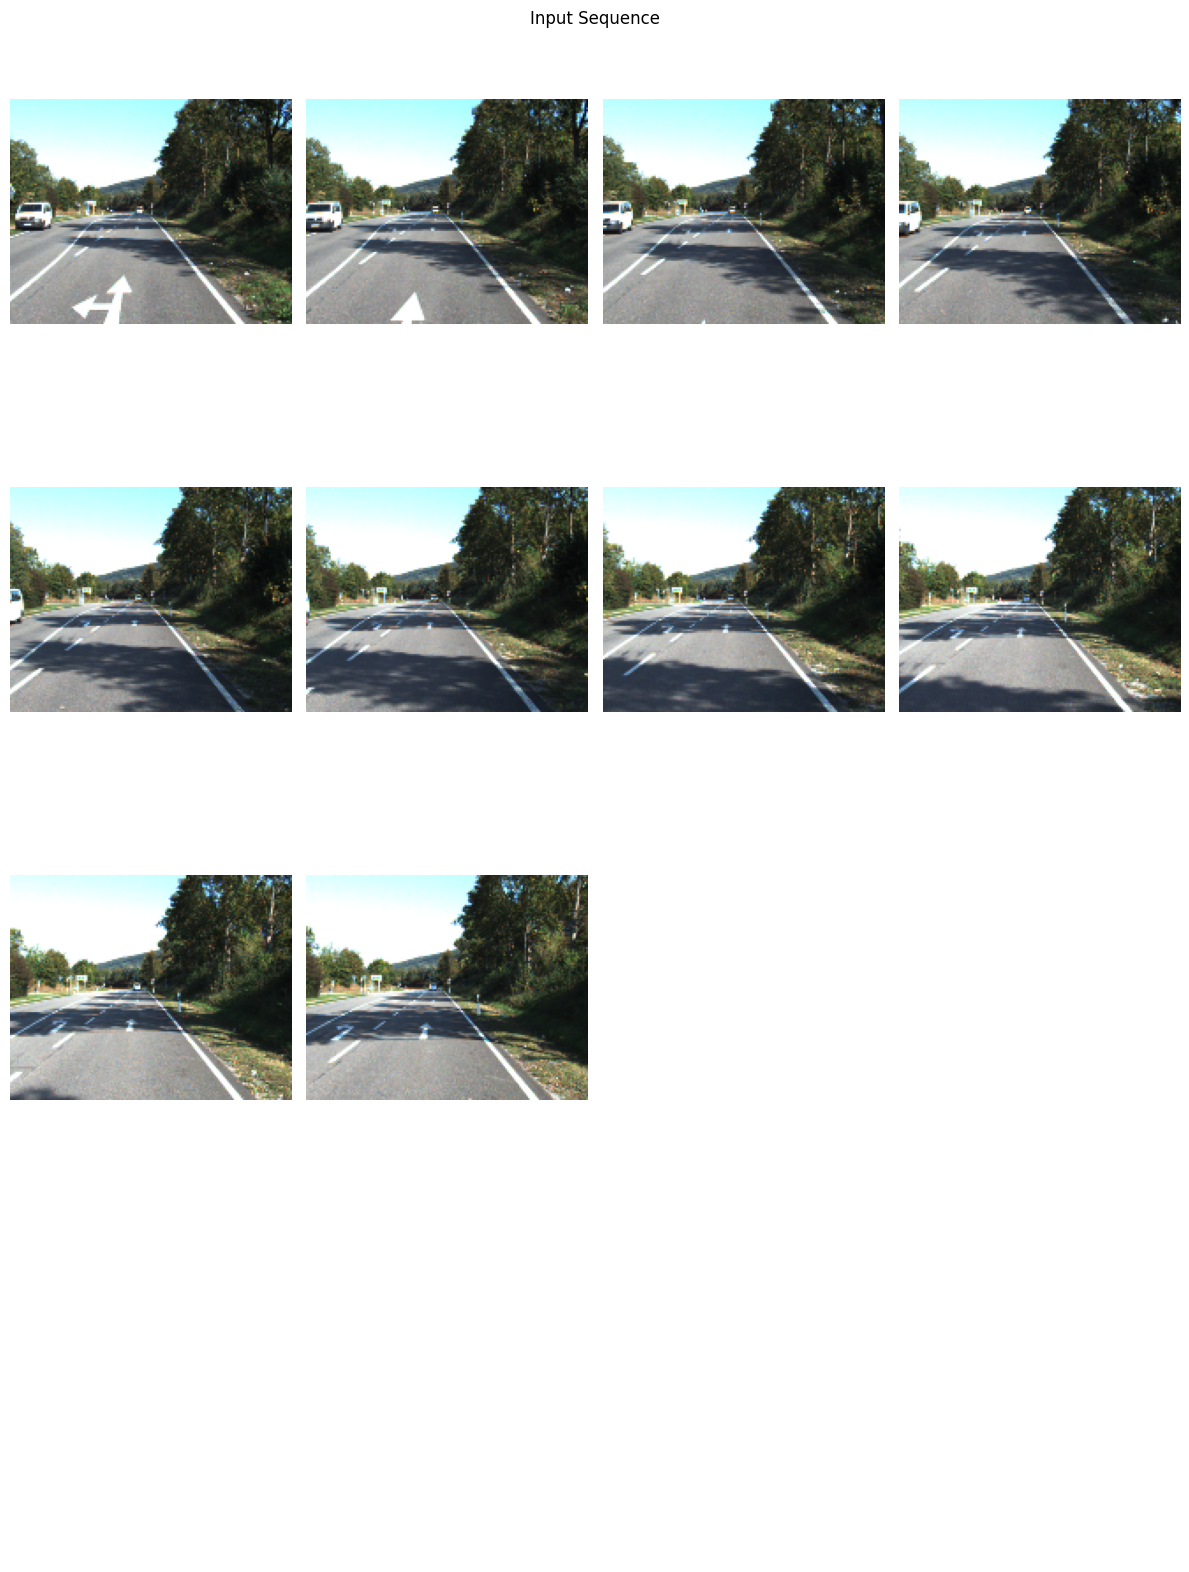

In [ ]:
inputs = results["inputs"][0] # Shape: [pre_seq_length, 3, 128,160]

# Plot the images inside the batch element
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,16))
axes=axes.flatten()
for i, ax in enumerate(axes):
    # Get the image tensor
    input_img = inputs[i].transpose(1,2,0)

    if grayscale:
      ax.imshow(input_img,cmap='gray')
    else:
      ax.imshow(input_img)
    ax.axis('off')
    if i==inputs.shape[0]-1:
      break
for j in range(pre_seq_length,nrows*ncols):
  axes[j].axis('off')

fig.suptitle("Input Sequence")
plt.tight_layout()
plt.show()
